I'm going to compare Stijn's model and mine here.

In [2]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## My Model

In [3]:
class ResulDualOutputBNN(nn.Module):
    def __init__(self, no_of_neurones, dropout_prob):
        super(ResulDualOutputBNN, self).__init__()
        self.shared_layer = nn.Sequential( #this is the input layer
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        self.output_layer_y0 = nn.Sequential( #this is the output layer for y0
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        )
        self.output_layer_y1 = nn.Sequential( #this is the output layer for y1
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        )


    def forward(self, x): #this is the forward pass, run automatically when you call the model
        shared = self.shared_layer(x)
        y0 = self.output_layer_y0(shared)
        y1 = self.output_layer_y1(shared)
        return y0, y1

## Stijn's Model

In [4]:
class StijnDualOutputBNN(nn.Module):
    def __init__(self, no_of_neurones, dropout_prob):
        super(StijnDualOutputBNN, self).__init__()
        self.shared_layer = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2,
                        out_features=no_of_neurones),
        nn.ReLU(),
        nn.Dropout(dropout_prob),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones,
                        out_features=no_of_neurones),
        )

        self.output_layer_y0 = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones,
                        out_features=1),
        )
        self.output_layer_y1 = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones,
                        out_features=1),
        )

    def forward(self, x):
        shared = self.shared_layer(x)
        y0 = self.output_layer_y0(shared)
        y1 = self.output_layer_y1(shared)
        return y0, y1

For each model, I'll:
* Generate a dataset
* Initialise the model
* Train the model
* Test the model
* Find its MSE, residuals, and standard deviation
* Plot it all

## Initialising the Model

In [5]:
def initialise_model(model_name, no_of_neurones: int, dropout_prob: float, lr: float = 0.01) -> tuple:
    """
    Initialise the DualOutputBNN model with its loss functions and optimizer.

    Parameters:
    - no_of_neurones (int): Number of neurons in the hidden layer.
    - dropout_prob (float): Dropout probability.
    - lr (float): Learning rate for the optimizer. Default is 0.01.

    Returns:
    - A tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    """

    #make a model from ResulDualOutputBNN if model_name is 'Resul' and from StijnDualOutputBNN if model_name is 'Stijn'
    match model_name.lower():
        case 'resul':
            model = ResulDualOutputBNN(no_of_neurones, dropout_prob).to(device)
        case 'stijn':
            model = StijnDualOutputBNN(no_of_neurones, dropout_prob).to(device)
        case _:
            raise ValueError(f"Model name {model_name} is not valid. Please use either 'Resul' or 'Stijn'.")

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model.train(), mse_loss, kl_loss, kl_weight, optimizer

## Initialising the Dataset

In [6]:
def initialise_dataset():
    #forming initial dataset
    x0, x1 = torch.rand(2000)*6 - 3, torch.rand(2000)*6 - 3
    df = pd.DataFrame({'x0': x0, 'x1': x1})

    #declaring target functions and their outputs
    clean_f0 = lambda x0, x1: 4*np.power(x0, 5) + 12*np.power(x1, 3) - 5
    clean_f1 = lambda x0, x1: 3*np.power(x0, 4) - 7*np.power(x1, 2) + 9*x0*x1

    clean_y0, clean_y1 = clean_f0(x0, x1), clean_f1(x0, x1)

    #declaring noisy functions and their outputs
    max_y0_scale, max_y1_scale = clean_y0.max()*0.2, clean_y1.max()*0.2 #scale for noisy function
    f0 = lambda x0, x1: clean_f0(x0, x1) + (max_y0_scale*torch.rand(x0.size()) - max_y0_scale/2)
    f1 = lambda x0, x1: clean_f1(x0, x1) + (max_y1_scale*torch.rand(x0.size()) - max_y1_scale/2)

    return df, f0, f1

## Generating the Dataset

In [7]:
def generate_dataset(df: pd.DataFrame, func0, func1):
    #splitting data into training and testing sets
    x_train, x_test = train_test_split(df[["x0", "x1"]], test_size=0.2, random_state=1)
    x_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)

    x_train = x_train.apply(lambda x: x.sort_values().values)
    x_test = x_test.apply(lambda x: x.sort_values().values)
    
    #generating y values
    y_train, y_test = pd.DataFrame(), pd.DataFrame()
    y_train["y0"], y_train["y1"] = func0(torch.Tensor(x_train["x0"]), torch.Tensor(x_train["x1"])), func1(torch.Tensor(x_train["x0"]), torch.Tensor(x_train["x1"]))
    y_test["y0"], y_test["y1"] = func0(torch.Tensor(x_test["x0"]), torch.Tensor(x_test["x1"])), func1(torch.Tensor(x_test["x0"]), torch.Tensor(x_test["x1"]))

    #normalising dataset
    normalise = lambda x: (x - np.mean(x)) / (np.std(x))
    x_train["x0"], x_train["x1"] = normalise(x_train["x0"]), normalise(x_train["x1"])
    x_test["x0"], x_test["x1"] = normalise(x_test["x0"]), normalise(x_test["x1"])

    y_train["y0"], y_train["y1"] = normalise(y_train["y0"]), normalise(y_train["y1"])
    y_test["y0"], y_test["y1"] = normalise(y_test["y0"]), normalise(y_test["y1"])

    return torch.Tensor(np.array(x_train)), torch.Tensor(np.array(x_test)), torch.Tensor(np.array(y_train)), torch.Tensor(np.array(y_test))

## Training the Model

In [8]:
def train_model(model_attributes, x_train, y_train, epochs: int, filename):
    """
    Train a Bayesian Neural Network model for a specified number of epochs.

    Parameters:
    - model_attributes: A tuple containing the model, loss functions, kl_weight, and optimizer.
    - x_train (torch.Tensor): Input tensor for the training data.
    - y_train (torch.Tensor): Target tensor for the training data.
    - epochs (int): Number of epochs to train the model.

    Returns:
    - model (torch.nn.Sequential): The trained neural network model.

    Ensures that training data and model are on the same device for efficiency.
    """

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes
    x_train, y_train = x_train.to(device), y_train.to(device)

    for _ in range(epochs):
        y0_pred, y1_pred = model(x_train)
        y0_mse, y1_mse = mse_loss(y0_pred, torch.unsqueeze(y_train[:,0], dim=1)), mse_loss(y1_pred, torch.unsqueeze(y_train[:,1], dim=1))
        kl = kl_loss(model)
        y0_cost, y1_cost = y0_mse + kl_weight * kl, y1_mse + kl_weight * kl
        cost = y0_cost + y1_cost

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    print(f"Cost: {cost.item():.3f}")

    x_train, y_train = x_train.cpu(), y_train.cpu()
    return model.eval().cpu()

## Testing the Model

In [9]:
def test_model(model, x_test):
    """
    Test a Bayesian Neural Network model to produce predictions along with mean and standard deviation.

    Parameters:
    - model (torch.nn.Sequential): The trained neural network model.
    - func (callable): The target function to compare against the model's predictions.

    Returns:
    - mean_model_results (numpy.ndarray): Array of mean predictions from the model.
    - std_model_results (numpy.ndarray): Array of standard deviations of the predictions.
    - x_test (torch.Tensor): Testing dataset inputs.
    - y_test (torch.Tensor): Testing dataset targets.

    The testing data is moved to the device specified by the global `device` variable.
    """

    y0_pred, y1_pred = np.array([model(x_test)[0].detach().numpy() for _ in range(500)])[:,:,0].T, np.array([model(x_test)[1].detach().numpy() for _ in range(500)])[:,:,0].T

    mean_y0_results, std_y0_results = np.array([np.mean(y0_pred[i]) for i in range(y0_pred.shape[0])]), np.array([np.std(y0_pred[i]) for i in range(y0_pred.shape[0])])
    mean_y1_results, std_y1_results = np.array([np.mean(y1_pred[i]) for i in range(y1_pred.shape[0])]), np.array([np.std(y1_pred[i]) for i in range(y1_pred.shape[0])])

    return mean_y0_results, std_y0_results, mean_y1_results, std_y1_results 

## Generating Prediction Data

This is basically a function where I combine all of the above, for a given model:

In [10]:
def generate_prediction_data(model_name, data, filename):
    x_train, x_test, y_train, y_test = data
    df_test = pd.DataFrame({'x0': x_test[:,0], 'x1': x_test[:,1], 'y0': y_test[:,0], 'y1': y_test[:,1]}).reset_index(drop=True)
    df_test.to_csv(f"../../data/model_comparator/{filename}/data.csv") 

    #where the machine learning occurs...
    model_attributes = initialise_model(model_name, 1000, 0.3)
    model = train_model(model_attributes, x_train, y_train, 1000, filename)
    mean_y0_results, std_y0_results, mean_y1_results, std_y1_results = test_model(model, x_test)

    mean_y0_mse, mean_y1_mse = model_attributes[1](torch.Tensor(mean_y0_results), y_test[:,0]), model_attributes[1](torch.Tensor(mean_y1_results), y_test[:,1])

    print(f"For {filename}'s model:")
    print(f"mean_y0_mse: {mean_y0_mse}, mean_y1_mse: {mean_y1_mse}")
    print(f"mean std(y0): {np.mean(std_y0_results)}, mean std(y1): {np.mean(std_y1_results)}")

    df_pred = pd.DataFrame({'x0': x_test[:,0], 'x1': x_test[:,1], 'y0': y_test[:,0], 'y1': y_test[:,1], 'mean_y0': mean_y0_results, 'mean_y1': mean_y1_results, 'std_y0': std_y0_results, 'std_y1': std_y1_results}).reset_index(drop=True)
    return df_pred

In [11]:
#generating dataset
initial_df, func0, func1 = initialise_dataset()
test_and_trains = generate_dataset(initial_df, func0, func1)

In [12]:
my_model_data = generate_prediction_data("resul", test_and_trains, "resul")
my_model_data.to_csv("../../data/model_comparator/resul/model_predictions.csv")

Cost: 0.856
For resul's model:
mean_y0_mse: 0.10919873416423798, mean_y1_mse: 0.13633646070957184
mean std(y0): 0.19888648390769958, mean std(y1): 0.23704959452152252


In [13]:
stijn_model_data = generate_prediction_data("stijn", test_and_trains, "stijn")
stijn_model_data.to_csv("../../data/model_comparator/stijn/model_predictions.csv")

Cost: 1.205
For stijn's model:
mean_y0_mse: 0.0896306112408638, mean_y1_mse: 0.09444116801023483
mean std(y0): 0.685549795627594, mean std(y1): 0.6268153190612793


My model is similar to my supervisor's in performance, but has a narrower confidence interval. In other words, my model is equally accurate, but more precise.

I'm now going to see how much my model's predictions differ from $y_{0}, y_{1}$'s actual values: as in, I'm going to plot their residuals.

I'm going to do the same for their standard deviations, to visualise how the width of my model's confidence interval fluctuates with $x_{0}, x_{1}$.

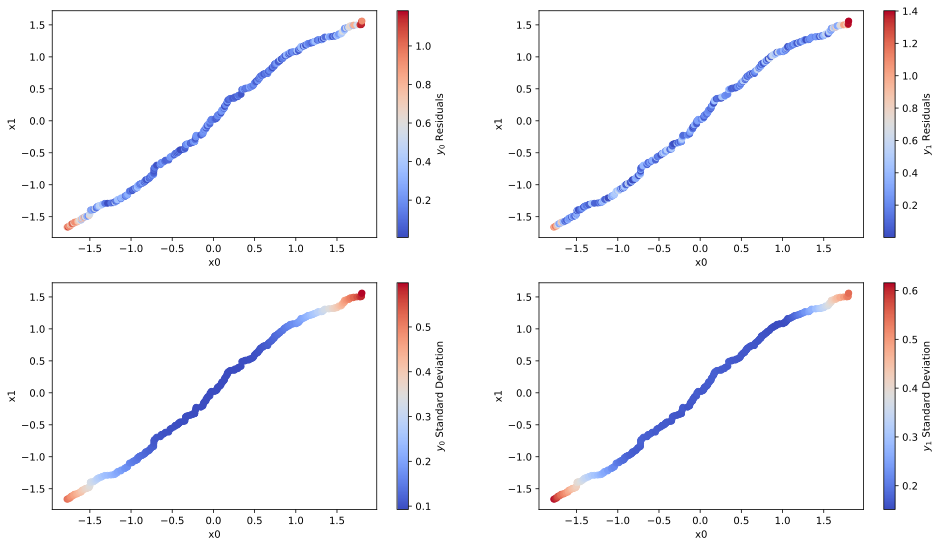

In [39]:
#form a colour plot of my_model_data
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 9))

# Subplot 1
scatter1 = axs[0, 0].scatter(my_model_data["x0"], my_model_data["x1"], c=np.abs(my_model_data["mean_y0"] - my_model_data["y0"]), cmap="coolwarm")
axs[0, 0].set_xlabel("x0")
axs[0, 0].set_ylabel("x1")
colorbar1 = fig.colorbar(scatter1, ax=axs[0, 0])  # Create colorbar for subplot 1
colorbar1.set_label('$y_{0}$ Residuals')

# Subplot 2
scatter2 = axs[0, 1].scatter(my_model_data["x0"], my_model_data["x1"], c=np.abs(my_model_data["mean_y1"] - my_model_data["y1"]), cmap="coolwarm")
axs[0, 1].set_xlabel("x0")
axs[0, 1].set_ylabel("x1")
colorbar2 = fig.colorbar(scatter2, ax=axs[0, 1])  # Create colorbar for subplot 2
colorbar2.set_label('$y_{1}$ Residuals')

# Subplot 3
scatter3 = axs[1, 0].scatter(my_model_data["x0"], my_model_data["x1"], c=my_model_data["std_y0"], cmap="coolwarm")
axs[1, 0].set_xlabel("x0")
axs[1, 0].set_ylabel("x1")
colorbar3 = fig.colorbar(scatter3, ax=axs[1, 0])  # Create colorbar for subplot 3
colorbar3.set_label('$y_{0}$ Standard Deviation')

# Subplot 4
scatter4 = axs[1, 1].scatter(my_model_data["x0"], my_model_data["x1"], c=my_model_data["std_y1"], cmap="coolwarm")
axs[1, 1].set_xlabel("x0")
axs[1, 1].set_ylabel("x1")
colorbar4 = fig.colorbar(scatter4, ax=axs[1, 1])  # Create colorbar for subplot 4
colorbar4.set_label('$y_{1}$ Standard Deviation')

plt.savefig("../../plots/model_comparator/residuals_and_std.png")
